In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from math import sqrt
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

To forecast the sales of the two best-selling products, I will split the dataset into two, one for item A and one for item B.

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv')

# Keep only one observation per day
data = data.drop_duplicates(subset=['date', 'item_name'], keep='first')

# Filter the data for item_name 'A'
data_a = data[data['item_name'] == 'A']

# Filter the data for item_name 'B'
data_b = data[data['item_name'] == 'B']

# Save the filtered data to new CSV files
data_a.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_A.csv', index=False)
data_b.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_B.csv', index=False)

Since statistical models don't require any variables to issue a forecast, I'm going to modify the file to have only two columns: one for the date and one for the number of associated sales per day.

In [ ]:
data_A = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_A.csv')

# Convert the date column to datetime type
data_A['date'] = pd.to_datetime(data['date'])

# Set the date column as the index of the DataFrame
data_A.set_index('date', inplace=True)

# Convert the index to datetime format
data_A.index = pd.to_datetime(data_A.index)

# Create a new DataFrame with only the 'unit_sales' column
final_data_A = data_A[['unit_sales']]

# Show the first few rows of the DataFrame
print(final_data_A.head())

            unit_sales
date                  
2015-01-02         117
2015-01-03         110
2015-01-04         180
2015-01-05         106
2015-01-06          87


In [ ]:
data_B = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_B.csv')

# Convert the date column to datetime type
data_B['date'] = pd.to_datetime(data['date'])

# Set the date column as the index of the DataFrame
data_B.set_index('date', inplace=True)

# Convert the index to datetime format
data_B.index = pd.to_datetime(data_B.index)

# Create a new DataFrame with only the 'unit_sales' column
final_data_B = data_B[['unit_sales']]

# Show the first few rows of the DataFrame
print(final_data_B.head())

            unit_sales
date                  
2015-01-02          90
2015-01-03          97
2015-01-04          94
2015-01-05          81
2015-01-06         119


Dataset A and B: Training set of 6 month history before the start of the evaluation period (evaluation period = May 2016)

In [ ]:
# Two years of data
dataset_stat_A = final_data_A['2015-01-01':'2017-01-01']
dataset_stat_B = final_data_B['2015-01-01':'2017-01-01']

# Calculate the start date six months before the test start date
historical_start_date = pd.to_datetime('2016-04-30') - pd.DateOffset(months=6)

# Calculate the end date as the test start date
historical_end_date = pd.to_datetime('2016-04-30')

# Filter the historical data for six months period prior to the test start date
train_A = final_data_A[(final_data_A.index >= historical_start_date) & (final_data_A.index < historical_end_date)]
train_B = final_data_B[(final_data_B.index >= historical_start_date) & (final_data_B.index < historical_end_date)]

# Display the first row of the train data
print("\nFirst row of train data:")
print(train_A)
print("Shape:", train_A.shape)

print("\nFirst row of train data:")
print(train_B)
print("Shape:", train_B.shape)


First row of train data:
            unit_sales
date                  
2015-10-30          39
2015-10-31          76
2015-11-01          55
2015-11-02          70
2015-11-03         106
...                ...
2016-04-25          55
2016-04-26          40
2016-04-27          52
2016-04-28          35
2016-04-29          66

[183 rows x 1 columns]
Shape: (183, 1)

First row of train data:
            unit_sales
date                  
2015-10-30          22
2015-10-31          71
2015-11-01          92
2015-11-02          85
2015-11-03          77
...                ...
2016-04-25          61
2016-04-26          88
2016-04-27          77
2016-04-28          63
2016-04-29          49

[183 rows x 1 columns]
Shape: (183, 1)


# Naïve Models

In order to compare models to a baseline, I will use the simplest forecasting models, called naive models.

Naïve forecasting involves using actual past sales from the last observed period to predict the value of the next period.

I will build two naïve forecasting models: one using the last week’s sales and another using the sales from the same day 4 weeks before (to measure monthly variance). May 2016 is the evaluation period for all models.

The first naïve method predicts the unit sales for each day in May 2016 by simply taking the unit sales value from the corresponding day one week prior.

The second naïve method predicts the unit sales for each day in May 2016 by simply taking the unit sales value from the corresponding day 4 weeks prior.

https://transimpact.in/nextsights/what-do-you-need-to-know-about-naive-forecasting/

In [ ]:
def naive_model_w1(data):
    # Initialize predictions dictionary
    predictions = {}

    # Iterate over each day in May 2016
    for date in pd.date_range(start='2016-05-01', end='2016-05-31'):
        # Find the date one week (7 days) before
        previous_week_date = date - pd.Timedelta(days=7)

        # Check if the previous week's date is in the dataset
        if previous_week_date in data.index:
            # Get the unit sales from the previous week's date
            prediction = data.loc[previous_week_date, 'unit_sales']
        else:
            # If the previous week's date is not available, set prediction as NaN
            prediction = None

        # Add prediction to the dictionary
        predictions[date] = prediction

    return predictions


In [ ]:
def naive_model_w4(data):
    # Initialize predictions dictionary
    predictions = {}

    # Iterate over each day in May 2016
    for date in pd.date_range(start='2016-05-01', end='2016-05-31'):
        # Find the date 4 weeks (28 days) before
        previous_month_date = date - pd.Timedelta(days=28)

        # Check if the previous month's date is in the dataset
        if previous_month_date in data.index:
            # Get the unit sales from the previous month's date
            prediction = data.loc[previous_month_date, 'unit_sales']
        else:
            # If the previous month's date is not available, set prediction as NaN
            prediction = None

        # Add prediction to the dictionary
        predictions[date] = prediction

    return predictions

Function to visualize the results

In [ ]:
def plot_forecast_vs_actual(predictions, actual_data, model_name):

    # Convert predictions dictionary to DataFrame for easier plotting
    pred_df = pd.DataFrame(list(predictions.items()), columns=['date', 'predicted_sales'])
    pred_df['date'] = pd.to_datetime(pred_df['date'])
    pred_df.set_index('date', inplace=True)

    # Plot settings
    plt.figure(figsize=(12, 6))
    plt.plot(pred_df.index, pred_df['predicted_sales'], label='Predicted Sales', marker='o', linestyle='-', color='blue')
    plt.plot(actual_data.index, actual_data['unit_sales'], label='Actual Sales', marker='x', linestyle='--', color='red')

    # Enhance the plot
    plt.title(f'{model_name} - Forecasted Sales vs Actual Sales')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate date labels for better readability

    # Show the plot
    plt.tight_layout()
    plt.show()

Function to evaluate the forecasts by comparing to actual sales. Different accuracy metrics are used:

*   RMSE
*   RMSE%
*   variance RMSE
*   MAE
*   MAPE
*   MAE%
*   Bias
*   Bias%

In [ ]:
def evaluate_forecast(predictions, actual_data):
    errors = []
    mae_values = []
    mape_values = []

    for date, pred in predictions.items():
        if date in actual_data.index:
            actual_sales = actual_data.at[date, 'unit_sales']
            error = pred - actual_sales
            errors.append(error)
            mae_values.append(abs(error))
            if actual_sales != 0:
                mape_values.append((abs(error) / actual_sales) * 100)

    # Calculate overall metrics
    actuals = [actual_data.at[date, 'unit_sales'] for date in predictions if date in actual_data.index]
    preds = [predictions[date] for date in predictions if date in actual_data.index]
    overall_rmse = sqrt(mean_squared_error(actuals, preds))
    overall_mae = np.mean(mae_values)  # Mean Absolute Error
    overall_mape = np.mean(mape_values) if mape_values else None  # Mean Absolute Percentage Error
    mae_percent = (np.sum(mae_values) / np.sum(actuals)) * 100 if actuals else None  # MAE as a percentage of total actuals
    bias = np.mean(errors) if errors else None  # Calculate bias
    bias_percent = (np.sum(errors) / np.sum(actuals)) * 100 if actuals else None  # Bias as a percentage of total actuals
    overall_rmse_percent = (overall_rmse / np.mean(actuals)) * 100 if actuals else None  # RMSE as a percentage of total actuals

    # Compute the variance of daily RMSEs
    variance_of_rmses = np.var([sqrt(mean_squared_error([actual], [pred])) for actual, pred in zip(actuals, preds)])

    # Format the output as a table
    results = {
        "Metric": ["Overall RMSE", "RMSE %", "Variance of RMSEs", "Overall MAE", "MAE %", "Overall MAPE", "Bias", "Bias %"],
        "Value": [overall_rmse, overall_rmse_percent, variance_of_rmses, overall_mae, mae_percent, overall_mape, bias, bias_percent]
    }

    return pd.DataFrame(results)

Model creation and evaluation

## Naïve Models 1 week

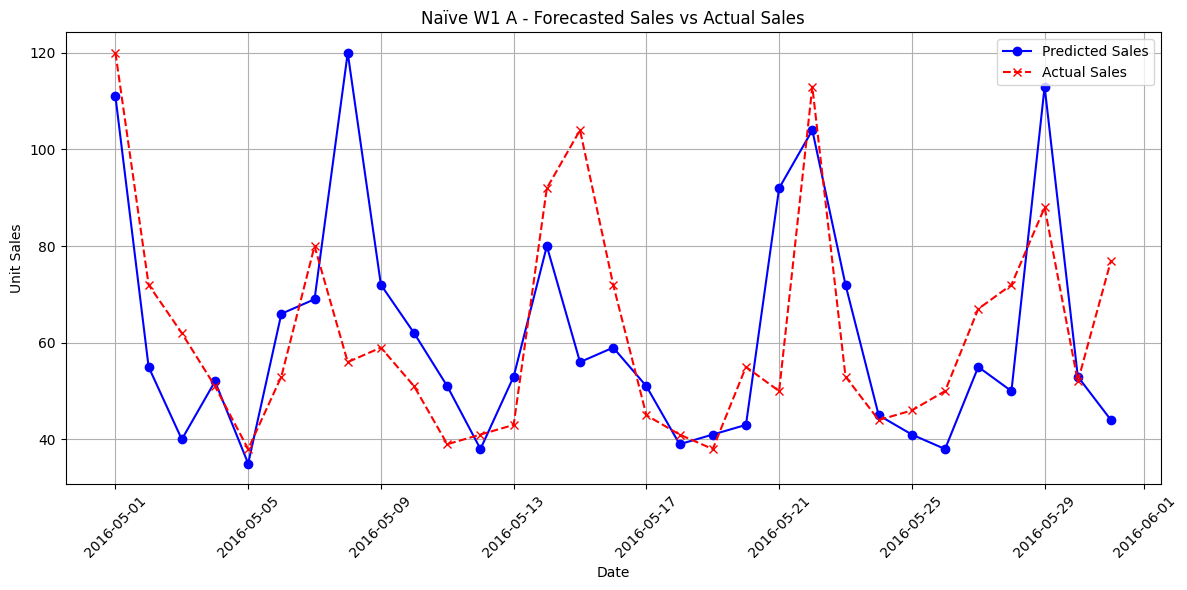

              Metric       Value
0       Overall RMSE   20.730218
1             RMSE %   33.401079
2  Variance of RMSEs  203.773153
3        Overall MAE   15.032258
4              MAE %   24.220374
5       Overall MAPE   24.056374
6               Bias   -0.774194
7             Bias %   -1.247401


In [ ]:
# Model Naive w1 A

# Define the dataset
dataset_stat_A = final_data_A['2015-01-01':'2017-01-01']

# Call the naive w1 model function
predictions_naive_w1_A = naive_model_w1(dataset_stat_A)

# Define actual sales data for May 2016
actual_data_naive_w1_A = dataset_stat_A['2016-05-01':'2016-05-31']

# Call the plotting function
model_name_naive_w1_A = 'Naïve W1 A'
plot_forecast_vs_actual(predictions_naive_w1_A, actual_data_naive_w1_A, model_name_naive_w1_A)

results_naive_w1_A = evaluate_forecast(predictions_naive_w1_A, actual_data_naive_w1_A)
print(results_naive_w1_A)

In [ ]:
# Model Naive w1 A

print("Sample predictions:")
for date in list(predictions_naive_w1_A.keys())[:]:
    print(f"{date}: {predictions_naive_w1_A[date]}")

Sample predictions:
2016-05-01 00:00:00: 111
2016-05-02 00:00:00: 55
2016-05-03 00:00:00: 40
2016-05-04 00:00:00: 52
2016-05-05 00:00:00: 35
2016-05-06 00:00:00: 66
2016-05-07 00:00:00: 69
2016-05-08 00:00:00: 120
2016-05-09 00:00:00: 72
2016-05-10 00:00:00: 62
2016-05-11 00:00:00: 51
2016-05-12 00:00:00: 38
2016-05-13 00:00:00: 53
2016-05-14 00:00:00: 80
2016-05-15 00:00:00: 56
2016-05-16 00:00:00: 59
2016-05-17 00:00:00: 51
2016-05-18 00:00:00: 39
2016-05-19 00:00:00: 41
2016-05-20 00:00:00: 43
2016-05-21 00:00:00: 92
2016-05-22 00:00:00: 104
2016-05-23 00:00:00: 72
2016-05-24 00:00:00: 45
2016-05-25 00:00:00: 41
2016-05-26 00:00:00: 38
2016-05-27 00:00:00: 55
2016-05-28 00:00:00: 50
2016-05-29 00:00:00: 113
2016-05-30 00:00:00: 53
2016-05-31 00:00:00: 44


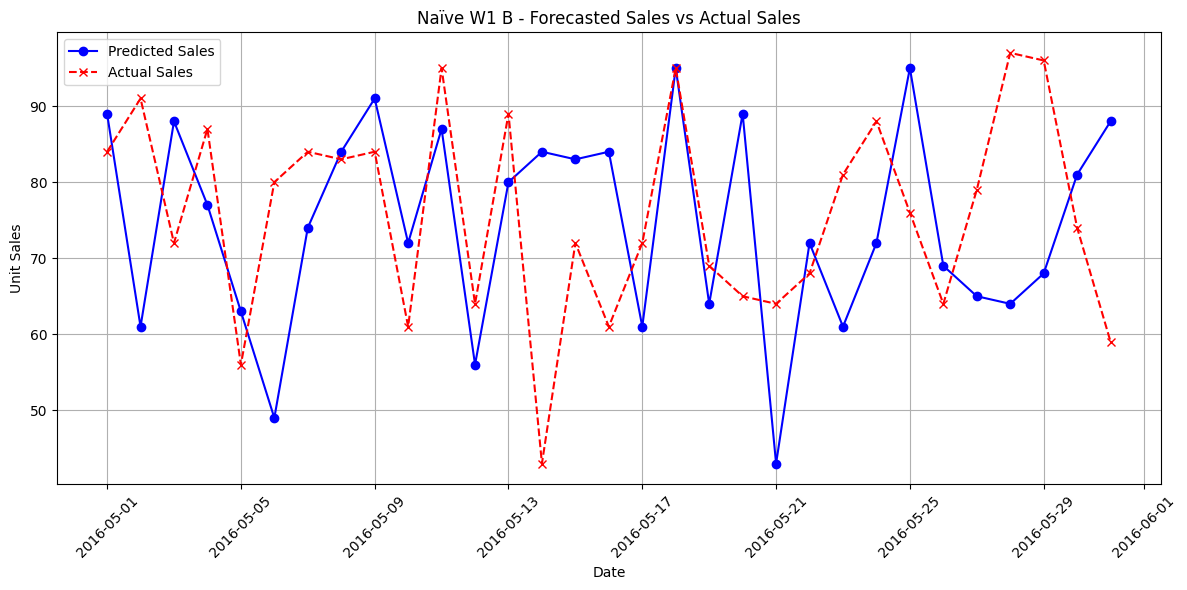

              Metric       Value
0       Overall RMSE   18.212013
1             RMSE %   23.993727
2  Variance of RMSEs  107.644121
3        Overall MAE   14.967742
4              MAE %   19.719507
5       Overall MAPE   21.163713
6               Bias   -1.419355
7             Bias %   -1.869953


In [ ]:
# Model Naive w1 B

# Define the dataset
dataset_stat_B = final_data_B['2015-01-01':'2017-01-01']

# Call the naive w1 model function
predictions_naive_w1_B = naive_model_w1(dataset_stat_B)

# Define actual sales data for May 2016
actual_data_naive_w1_B = dataset_stat_B['2016-05-01':'2016-05-31']

# Call the plotting function
model_name_naive_w1_B = 'Naïve W1 B'
plot_forecast_vs_actual(predictions_naive_w1_B, actual_data_naive_w1_B, model_name_naive_w1_B)

results_naive_w1_B = evaluate_forecast(predictions_naive_w1_B, actual_data_naive_w1_B)
print(results_naive_w1_B)

In [ ]:
# Model Naive w1 B

print("Sample predictions:")
for date in list(predictions_naive_w1_B.keys())[:]:
    print(f"{date}: {predictions_naive_w1_B[date]}")

Sample predictions:
2016-05-01 00:00:00: 89
2016-05-02 00:00:00: 61
2016-05-03 00:00:00: 88
2016-05-04 00:00:00: 77
2016-05-05 00:00:00: 63
2016-05-06 00:00:00: 49
2016-05-07 00:00:00: 74
2016-05-08 00:00:00: 84
2016-05-09 00:00:00: 91
2016-05-10 00:00:00: 72
2016-05-11 00:00:00: 87
2016-05-12 00:00:00: 56
2016-05-13 00:00:00: 80
2016-05-14 00:00:00: 84
2016-05-15 00:00:00: 83
2016-05-16 00:00:00: 84
2016-05-17 00:00:00: 61
2016-05-18 00:00:00: 95
2016-05-19 00:00:00: 64
2016-05-20 00:00:00: 89
2016-05-21 00:00:00: 43
2016-05-22 00:00:00: 72
2016-05-23 00:00:00: 61
2016-05-24 00:00:00: 72
2016-05-25 00:00:00: 95
2016-05-26 00:00:00: 69
2016-05-27 00:00:00: 65
2016-05-28 00:00:00: 64
2016-05-29 00:00:00: 68
2016-05-30 00:00:00: 81
2016-05-31 00:00:00: 88


## Naive Models 4 weeks

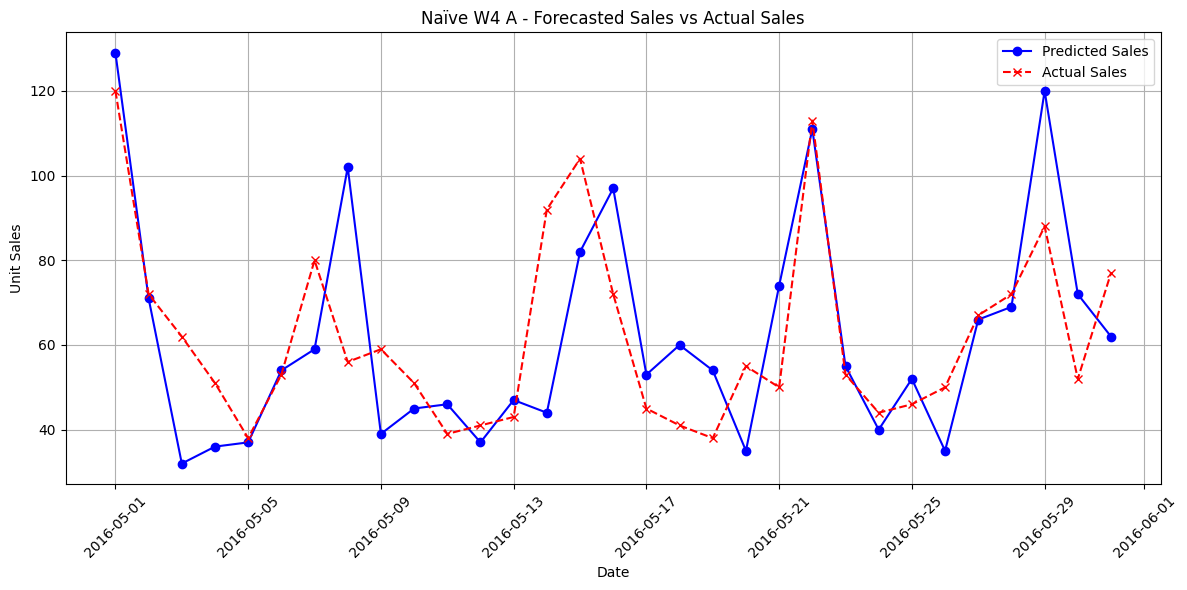

              Metric       Value
0       Overall RMSE   19.089771
1             RMSE %   30.757947
2  Variance of RMSEs  156.501561
3        Overall MAE   14.419355
4              MAE %   23.232848
5       Overall MAPE   23.824195
6               Bias   -0.290323
7             Bias %   -0.467775


In [ ]:
# Model Naive w4 A

# Define the dataset
dataset_stat_A = final_data_A['2015-01-01':'2017-01-01']

# Call the baseline model function
predictions_naive_w4_A = naive_model_w4(dataset_stat_A)

# Define actual sales data for May 2016
actual_data_naive_w4_A = dataset_stat_A['2016-05-01':'2016-05-31']

# Call the plotting function
model_name_naive_w4_A = 'Naïve W4 A'
plot_forecast_vs_actual(predictions_naive_w4_A, actual_data_naive_w4_A, model_name_naive_w4_A)

results_naive_w4_A = evaluate_forecast(predictions_naive_w4_A, actual_data_naive_w4_A)
print(results_naive_w4_A)

In [ ]:
# Model Naive w4 A

print("Sample predictions:")
for date in list(predictions_naive_w4_A.keys())[:]:
    print(f"{date}: {predictions_naive_w4_A[date]}")

Sample predictions:
2016-05-01 00:00:00: 129
2016-05-02 00:00:00: 71
2016-05-03 00:00:00: 32
2016-05-04 00:00:00: 36
2016-05-05 00:00:00: 37
2016-05-06 00:00:00: 54
2016-05-07 00:00:00: 59
2016-05-08 00:00:00: 102
2016-05-09 00:00:00: 39
2016-05-10 00:00:00: 45
2016-05-11 00:00:00: 46
2016-05-12 00:00:00: 37
2016-05-13 00:00:00: 47
2016-05-14 00:00:00: 44
2016-05-15 00:00:00: 82
2016-05-16 00:00:00: 97
2016-05-17 00:00:00: 53
2016-05-18 00:00:00: 60
2016-05-19 00:00:00: 54
2016-05-20 00:00:00: 35
2016-05-21 00:00:00: 74
2016-05-22 00:00:00: 111
2016-05-23 00:00:00: 55
2016-05-24 00:00:00: 40
2016-05-25 00:00:00: 52
2016-05-26 00:00:00: 35
2016-05-27 00:00:00: 66
2016-05-28 00:00:00: 69
2016-05-29 00:00:00: 120
2016-05-30 00:00:00: 72
2016-05-31 00:00:00: 62


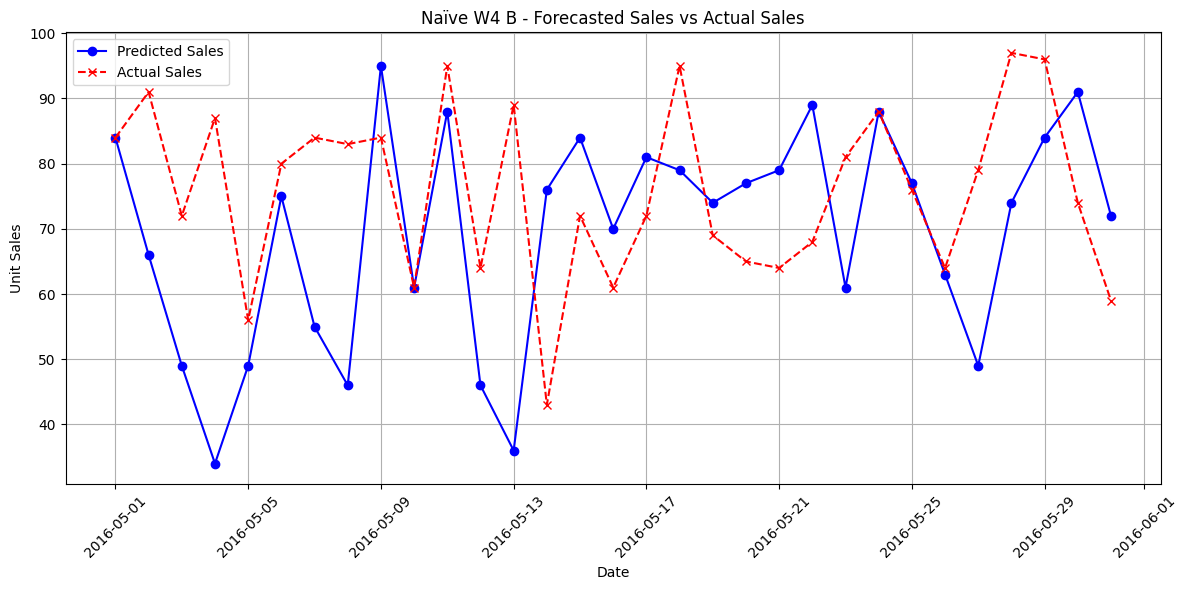

              Metric       Value
0       Overall RMSE   21.604211
1             RMSE %   28.462836
2  Variance of RMSEs  188.605619
3        Overall MAE   16.677419
4              MAE %   21.971951
5       Overall MAPE   22.278233
6               Bias   -6.483871
7             Bias %   -8.542286


In [ ]:
# Model Naive w4 B

# Define the dataset
dataset_stat_B = final_data_B['2015-01-01':'2017-01-01']

# Call the baseline model function
predictions_naive_w4_B = naive_model_w4(dataset_stat_B)

# Define actual sales data for May 2016
actual_data_naive_w4_B = dataset_stat_B['2016-05-01':'2016-05-31']

# Call the plotting function
model_name_naive_w4_B = 'Naïve W4 B'
plot_forecast_vs_actual(predictions_naive_w4_B, actual_data_naive_w4_B, model_name_naive_w4_B)

results_naive_w4_B = evaluate_forecast(predictions_naive_w4_B, actual_data_naive_w4_B)
print(results_naive_w4_B)

In [ ]:
# Model Naive w4 B

print("Sample predictions:")
for date in list(predictions_naive_w4_B.keys())[:]:
    print(f"{date}: {predictions_naive_w4_B[date]}")

Sample predictions:
2016-05-01 00:00:00: 84
2016-05-02 00:00:00: 66
2016-05-03 00:00:00: 49
2016-05-04 00:00:00: 34
2016-05-05 00:00:00: 49
2016-05-06 00:00:00: 75
2016-05-07 00:00:00: 55
2016-05-08 00:00:00: 46
2016-05-09 00:00:00: 95
2016-05-10 00:00:00: 61
2016-05-11 00:00:00: 88
2016-05-12 00:00:00: 46
2016-05-13 00:00:00: 36
2016-05-14 00:00:00: 76
2016-05-15 00:00:00: 84
2016-05-16 00:00:00: 70
2016-05-17 00:00:00: 81
2016-05-18 00:00:00: 79
2016-05-19 00:00:00: 74
2016-05-20 00:00:00: 77
2016-05-21 00:00:00: 79
2016-05-22 00:00:00: 89
2016-05-23 00:00:00: 61
2016-05-24 00:00:00: 88
2016-05-25 00:00:00: 77
2016-05-26 00:00:00: 63
2016-05-27 00:00:00: 49
2016-05-28 00:00:00: 74
2016-05-29 00:00:00: 84
2016-05-30 00:00:00: 91
2016-05-31 00:00:00: 72


# ARIMA models

## Check for stationarity

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a given time series is stationary. A time series is considered stationary if its statistical properties, such as mean and variance, are constant over time. Stationarity is needed for ARIMA model to perform well

In [ ]:
# Model ARIMA A

# Extract the 'unit_sales' column
unit_sales_A = dataset_stat_A['unit_sales']

adf_result_A = adfuller(unit_sales_A.dropna())  # Ensure there are no NaN values which can interfere with the test

print('ADF Statistic A:', adf_result_A[0])
print('p-value A:', adf_result_A[1])
print('Critical Values:')
for key, value in adf_result_A[4].items():
    print(f'\t{key}: {value}')

# Evaluate p-value to test for stationarity
if adf_result_A[1] < 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")

ADF Statistic A: -3.5458413645652396
p-value A: 0.006884946893385405
Critical Values:
	1%: -3.439606888036868
	5%: -2.865625121924057
	10%: -2.5689454046801052
The series is likely stationary.


In [ ]:
# Model ARIMA B

# Extract the 'unit_sales' column
unit_sales_B = dataset_stat_B['unit_sales']

adf_result_B = adfuller(unit_sales_B.dropna())  # Ensure there are no NaN values which can interfere with the test

print('ADF Statistic B:', adf_result_B[0])
print('p-value B:', adf_result_B[1])
print('Critical Values:')
for key, value in adf_result_B[4].items():
    print(f'\t{key}: {value}')

# Evaluate p-value to test for stationarity
if adf_result_B[1] < 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")

ADF Statistic B: -3.604889939784659
p-value B: 0.005668227805296247
Critical Values:
	1%: -3.4395289262948894
	5%: -2.8655907692307694
	10%: -2.5689271030368235
The series is likely stationary.


# Best ARIMA models

To select the best hyperparameters (p, d, q) for the ARIMA model, I will use a grid search approach to evaluate different combinations of these parameters and choose the one that results in the lowest RMSE (Root Mean Squared Error) on a validation dataset.

In [ ]:
# Model ARIMA A

# Function to evaluate ARIMA model with given parameters
def evaluate_arima_model_A(order, train, val):
    history = train.values.flatten()
    predictions = []
    for t in range(len(val)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history = np.append(history, val.iloc[t])
    rmse = mean_squared_error(val, predictions, squared=False)
    return rmse

# Define the range of values for p, d, q
p_range_ARIMA_A = range(0, 5)
d_range_ARIMA_A = [0]  # Only d=0 because stationary data
q_range_ARIMA_A = range(0, 5)

# Generate all possible combinations of p, d, q
pdq_ARIMA_A = list(itertools.product(p_range_ARIMA_A, d_range_ARIMA_A, q_range_ARIMA_A))

# Split train_A into train and validation sets
train_size_ARIMA_A = int(len(train_A) * 0.8)
train_ARIMA_A, val_ARIMA_A = train_A[:train_size_ARIMA_A], train_A[train_size_ARIMA_A:]

# Grid search to find the best parameters
best_rmse_ARIMA_A = float('inf')
best_params_ARIMA_A = None
for param_ARIMA_A in pdq_ARIMA_A:
    try:
        rmse_ARIMA_A = evaluate_arima_model_A(param_ARIMA_A, train_ARIMA_A, val_ARIMA_A)
        print('ARIMA%s RMSE=%.2f' % (param_ARIMA_A, rmse_ARIMA_A))
        if rmse_ARIMA_A < best_rmse_ARIMA_A:
            best_rmse_ARIMA_A = rmse_ARIMA_A
            best_params_ARIMA_A = param_ARIMA_A
    except:
        continue

print('Best ARIMA%s A RMSE=%.2f' % (best_params_ARIMA_A, best_rmse_ARIMA_A))

ARIMA(0, 0, 0) RMSE=24.55
ARIMA(0, 0, 1) RMSE=22.24
ARIMA(0, 0, 2) RMSE=22.44
ARIMA(0, 0, 3) RMSE=22.54
ARIMA(0, 0, 4) RMSE=21.72
ARIMA(1, 0, 0) RMSE=23.10
ARIMA(1, 0, 1) RMSE=22.25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 0, 2) RMSE=21.38
ARIMA(1, 0, 3) RMSE=22.05
ARIMA(1, 0, 4) RMSE=23.35
ARIMA(2, 0, 0) RMSE=21.91
ARIMA(2, 0, 1) RMSE=20.88


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(2, 0, 2) RMSE=18.95


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(2, 0, 3) RMSE=21.00


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(2, 0, 4) RMSE=18.26
ARIMA(3, 0, 0) RMSE=21.58
ARIMA(3, 0, 1) RMSE=20.85


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(3, 0, 2) RMSE=19.02


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(3, 0, 3) RMSE=18.74


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(3, 0, 4) RMSE=18.54
ARIMA(4, 0, 0) RMSE=20.16
ARIMA(4, 0, 1) RMSE=20.12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(4, 0, 2) RMSE=18.42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(4, 0, 3) RMSE=18.51


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(4, 0, 4) RMSE=19.86
Best ARIMA(2, 0, 4) A RMSE=18.26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Model ARIMA B

# Function to evaluate ARIMA model with given parameters
def evaluate_arima_model_B(order, train, val):
    history = train.values.flatten()
    predictions = []
    for t in range(len(val)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history = np.append(history, val.iloc[t])
    rmse = mean_squared_error(val, predictions, squared=False)
    return rmse

# Define the range of values for p, d, q
p_range_ARIMA_B = range(0, 5)
d_range_ARIMA_B = [0]  # Only d=0 because stationary data
q_range_ARIMA_B = range(0, 5)

# Generate all possible combinations of p, d, q
pdq_ARIMA_B = list(itertools.product(p_range_ARIMA_B, d_range_ARIMA_B, q_range_ARIMA_B))

# Split train_B into train and validation sets
train_size_ARIMA_B = int(len(train_B) * 0.8)
train_ARIMA_B, val_ARIMA_B = train_B[:train_size_ARIMA_B], train_B[train_size_ARIMA_B:]

# Grid search to find the best parameters
best_rmse_ARIMA_B = float('inf')
best_params_ARIMA_B = None
for param_ARIMA_B in pdq_ARIMA_B:
    try:
        rmse_ARIMA_B = evaluate_arima_model_B(param_ARIMA_B, train_ARIMA_B, val_ARIMA_B)
        print('ARIMA%s RMSE=%.2f' % (param_ARIMA_B, rmse_ARIMA_B))
        if rmse_ARIMA_B < best_rmse_ARIMA_B:
            best_rmse_ARIMA_B = rmse_ARIMA_B
            best_params_ARIMA_B = param_ARIMA_B
    except:
        continue

print('Best ARIMA%s B RMSE=%.2f' % (best_params_ARIMA_B, best_rmse_ARIMA_B))

ARIMA(0, 0, 0) RMSE=19.71
ARIMA(0, 0, 1) RMSE=19.85
ARIMA(0, 0, 2) RMSE=20.33
ARIMA(0, 0, 3) RMSE=20.47
ARIMA(0, 0, 4) RMSE=20.65
ARIMA(1, 0, 0) RMSE=19.52
ARIMA(1, 0, 1) RMSE=20.76


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 0, 2) RMSE=20.36


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 0, 3) RMSE=20.32
ARIMA(1, 0, 4) RMSE=20.12
ARIMA(2, 0, 0) RMSE=19.95
ARIMA(2, 0, 1) RMSE=20.47


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 2) RMSE=20.32


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

ARIMA(2, 0, 3) RMSE=20.19


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(2, 0, 4) RMSE=20.32
ARIMA(3, 0, 0) RMSE=20.09
ARIMA(3, 0, 1) RMSE=20.41


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) RMSE=20.30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(3, 0, 3) RMSE=20.78


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(3, 0, 4) RMSE=22.03
ARIMA(4, 0, 0) RMSE=20.42
ARIMA(4, 0, 1) RMSE=20.65


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

ARIMA(4, 0, 3) RMSE=20.22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA(4, 0, 4) RMSE=20.82
Best ARIMA(1, 0, 0) B RMSE=19.52


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print('Best ARIMA%s A RMSE=%.2f' % (best_params_ARIMA_A, best_rmse_ARIMA_A))
print('Best ARIMA%s B RMSE=%.2f' % (best_params_ARIMA_B, best_rmse_ARIMA_B))

Best ARIMA(2, 0, 4) A RMSE=18.26
Best ARIMA(1, 0, 0) B RMSE=19.52


## Model évaluation

**Model Training and Forecasting Strategy:**

Real-World Simulation: The model emulates real-world scenarios by generating daily forecasts for the next day, utilizing a rolling window approach with the last six months of data to continuously train the model.

Dynamic Training Data: The dataset for training is refreshed daily, incorporating the most recent six months' data. This ensures that each forecast is based on the latest trends and information. Each training set produces a forecast for the immediate following day.

**Evaluation Period and Methodology:**

Testing Timeline: The model's effectiveness is evaluated over a 31-day span, from May 1, 2016, to May 31, 2016.

Comparison of Predicted and Actual Sales: Daily forecasted sales are matched against actual sales figures for each corresponding day. The forecasts represent the mean outcome from the bootstrapped models.

Performance Metric: The accuracy of the model is measured using:

*   RMSE
*   RMSE%
*   variance RMSE
*   MAE
*   MAPE
*   MAE%
*   Bias
*   Bias%

This methodology ensures that the model is resilient, adjusts to current market conditions, and reflects a realistic operational forecasting process.

In [ ]:
def prepare_training_data(data, start_date, end_date):

    # Calculate the start of the training period (6 months before the start_date)
    train_start = pd.to_datetime(start_date) - timedelta(days=180)
    train_end = pd.to_datetime(start_date) - timedelta(days=1)

    # Extract the training data from the dataset
    training_data = data[train_start:train_end]

    return training_data

In [ ]:
def forecast_sales_ARIMA_A(data, test_start_date, test_end_date):
    current_date = pd.to_datetime(test_start_date)
    end_date = pd.to_datetime(test_end_date)
    predictions = {}
    training_dates = []

    while current_date <= end_date:
        # Prepare training data for the current day
        train_data = prepare_training_data(data, str(current_date), str(current_date))
        train_start = current_date - timedelta(days=180)
        train_end = current_date - timedelta(days=1)

        # Train ARIMA model
        train_target = train_data['unit_sales']
        arima_model = ARIMA(train_target, order=(2, 0, 4))
        arima_model_fit = arima_model.fit()

        # Predict for the current day
        prediction = arima_model_fit.forecast(steps=1)
        predictions[current_date.strftime('%Y-%m-%d')] = prediction[0]

        # Log training set start and end dates
        training_dates.append({'date': current_date.strftime('%Y-%m-%d'), 'start': train_start, 'end': train_end})

        # Move to the next day
        current_date += timedelta(days=1)

    return predictions, training_dates

In [ ]:
def forecast_sales_ARIMA_B(data, test_start_date, test_end_date):
    current_date = pd.to_datetime(test_start_date)
    end_date = pd.to_datetime(test_end_date)
    predictions = {}
    training_dates = []

    while current_date <= end_date:
        # Prepare training data for the current day
        train_data = prepare_training_data(data, str(current_date), str(current_date))
        train_start = current_date - timedelta(days=180)
        train_end = current_date - timedelta(days=1)

        # Train ARIMA model
        train_target = train_data['unit_sales']
        arima_model = ARIMA(train_target, order=(1, 0, 0))
        arima_model_fit = arima_model.fit()

        # Predict for the current day
        prediction = arima_model_fit.forecast(steps=1)
        predictions[current_date.strftime('%Y-%m-%d')] = prediction[0]

        # Log training set start and end dates
        training_dates.append({'date': current_date.strftime('%Y-%m-%d'), 'start': train_start, 'end': train_end})

        # Move to the next day
        current_date += timedelta(days=1)

    return predictions, training_dates

## Result Model ARIMA A

Forecast the value for the evaluation period

In [ ]:
# Model ARIMA A

# Define the testing period
test_start_date_ARIMA_A = '2016-05-01'
test_end_date_ARIMA_A = '2016-05-31'

# Run the forecast
predictions_ARIMA_A, training_dates_ARIMA_A = forecast_sales_ARIMA_A(dataset_stat_A, test_start_date_ARIMA_A, test_end_date_ARIMA_A)
print("Forecasting completed.")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

Forecasting completed.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


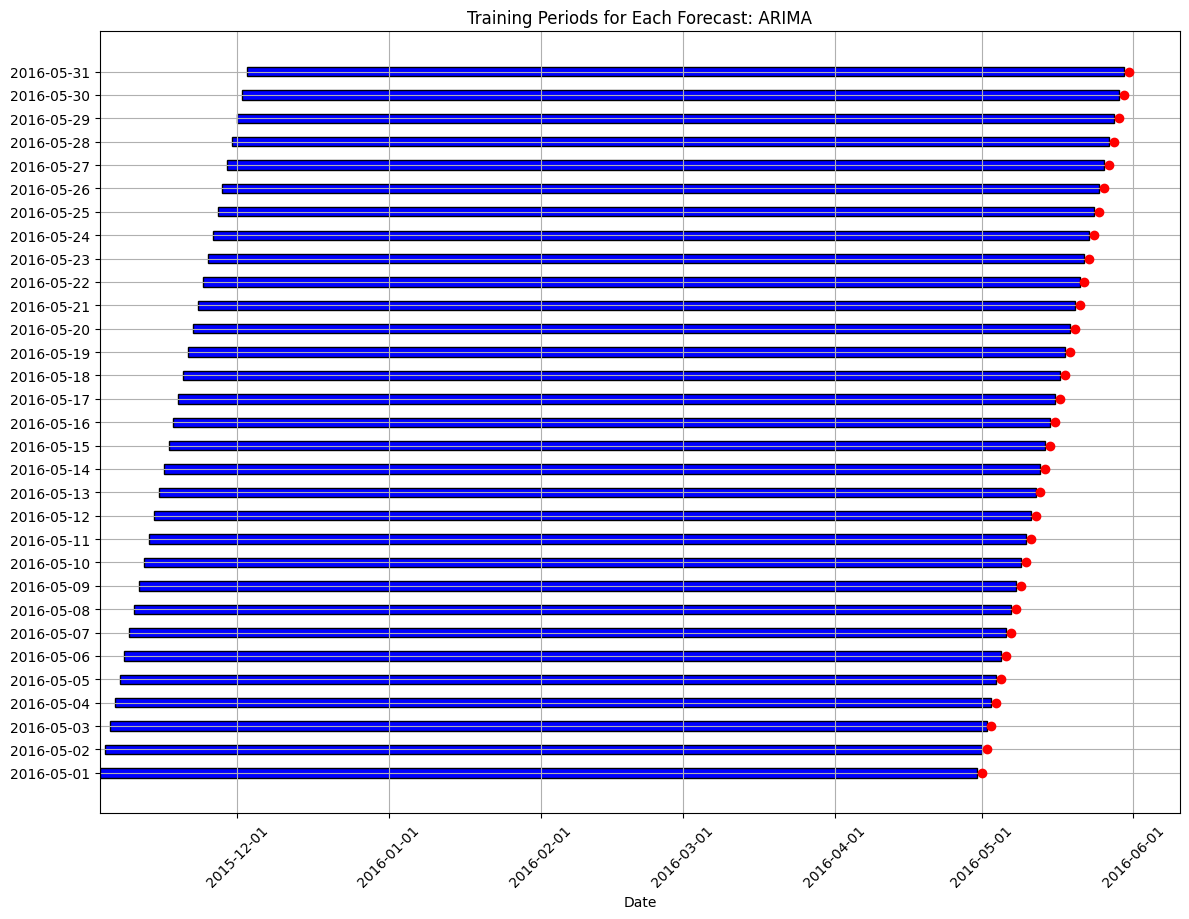

In [ ]:
def visualize_training_periods(training_dates):

    # Prepare figure and axes
    fig, ax = plt.subplots(figsize=(12, len(training_dates) * 0.3))  # Adjust size as needed

    # Generate bars for each training period
    for i, dates in enumerate(training_dates):
        start_date = dates['start']
        end_date = dates['end']
        forecast_date = end_date + pd.Timedelta(days=1)

        # Draw the training period bar
        ax.barh(i, (end_date - start_date).days, left=start_date, color='blue', edgecolor='black', height=0.4)

        # Draw a point for the forecasted day
        ax.plot(forecast_date, i, 'ro')

    # Set labels and titles
    ax.set_yticks(range(len(training_dates)))
    ax.set_yticklabels([dates['date'] for dates in training_dates])
    ax.set_xlabel('Date')
    ax.set_title('Training Periods for Each Forecast: ARIMA')

    # Improve date display
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function
visualize_training_periods(training_dates_ARIMA_A)

Evaluate the results

In [ ]:
# Model ARIMA A

# Extract actual sales data for the test period
actual_data_ARIMA_A = dataset_stat_A[test_start_date_ARIMA_A:test_end_date_ARIMA_A]

# Check actual data extraction
print("Checking actual data extraction...")
if actual_data_ARIMA_A.empty:
    print("Error: Actual data extraction returned an empty DataFrame.")
else:
    print(f"Actual data extracted for {len(actual_data_ARIMA_A)} days.")

results_ARIMA_A = evaluate_forecast(predictions_ARIMA_A, actual_data_ARIMA_A)
print(results_ARIMA_A)

Checking actual data extraction...
Actual data extracted for 31 days.
              Metric       Value
0       Overall RMSE   16.142676
1             RMSE %   26.009509
2  Variance of RMSEs  120.144571
3        Overall MAE   11.850798
4              MAE %   19.094321
5       Overall MAPE   18.863465
6               Bias    0.944828
7             Bias %    1.522332


Predicted value for each day

In [ ]:
# Model ARIMA A

print("Sample predictions:")
for date in list(predictions_ARIMA_A.keys())[:]:
    print(f"{date}: {predictions_ARIMA_A[date]}")

Sample predictions:
2016-05-01: 83.26174104623298
2016-05-02: 81.31913861557734
2016-05-03: 46.15182177612098
2016-05-04: 42.04941110152511
2016-05-05: 41.5828415958192
2016-05-06: 59.80341890619934
2016-05-07: 80.58996340798322
2016-05-08: 87.20977280831676
2016-05-09: 70.40232374469677
2016-05-10: 53.79744388610006
2016-05-11: 39.78835990553786
2016-05-12: 42.98382511097387
2016-05-13: 60.273557718618434
2016-05-14: 79.279406960073
2016-05-15: 89.229747887415
2016-05-16: 72.82123086219858
2016-05-17: 50.472778601988445
2016-05-18: 38.670530398724004
2016-05-19: 44.811095129756936
2016-05-20: 61.197098807887954
2016-05-21: 81.81487610515086
2016-05-22: 81.95158560718374
2016-05-23: 82.7609520553136
2016-05-24: 44.64233821331686
2016-05-25: 43.00945289909856
2016-05-26: 43.7621290606821
2016-05-27: 62.92083557517632
2016-05-28: 80.80020814095917
2016-05-29: 83.16764551101815
2016-05-30: 74.26097799592242
2016-05-31: 48.5031542318664


Visualization of the results

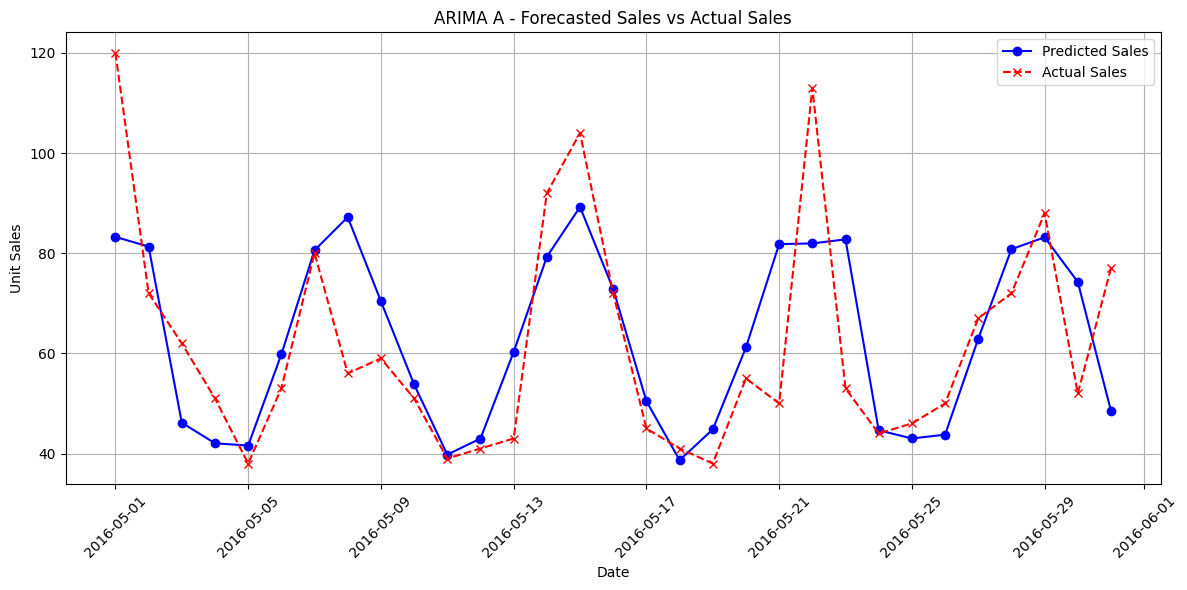

In [ ]:
# Model ARIMA A

model_name_ARIMA_A = 'ARIMA A'
plot_forecast_vs_actual(predictions_ARIMA_A, actual_data_ARIMA_A, model_name_ARIMA_A)

## Result Model ARIMA B

Forecast the value for the evaluation period

In [ ]:
# Model ARIMA B

# Define the testing period
test_start_date_ARIMA_B = '2016-05-01'
test_end_date_ARIMA_B = '2016-05-31'

# Run the forecast
predictions_ARIMA_B, training_dates_ARIMA_B = forecast_sales_ARIMA_B(dataset_stat_B, test_start_date_ARIMA_B, test_end_date_ARIMA_B)
print("Forecasting completed.")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Forecasting completed.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Evaluate the results

In [ ]:
# Model ARIMA B

# Extract actual sales data for the test period
actual_data_ARIMA_B = dataset_stat_B[test_start_date_ARIMA_B:test_end_date_ARIMA_B]

# Check actual data extraction
print("Checking actual data extraction...")
if actual_data_ARIMA_B.empty:
    print("Error: Actual data extraction returned an empty DataFrame.")
else:
    print(f"Actual data extracted for {len(actual_data_ARIMA_B)} days.")

results_ARIMA_B = evaluate_forecast(predictions_ARIMA_B, actual_data_ARIMA_B)
print(results_ARIMA_B)

Checking actual data extraction...
Actual data extracted for 31 days.
              Metric      Value
0       Overall RMSE  14.212930
1             RMSE %  18.725067
2  Variance of RMSEs  52.834103
3        Overall MAE  12.213651
4              MAE %  16.091083
5       Overall MAPE  16.768519
6               Bias  -3.062791
7             Bias %  -4.035127


Predicted value for each day

In [ ]:
# Model ARIMA B

print("Sample predictions:")
for date in list(predictions_ARIMA_B.keys())[:]:
    print(f"{date}: {predictions_ARIMA_B[date]}")

Sample predictions:
2016-05-01: 72.0941125355067
2016-05-02: 74.12285599155011
2016-05-03: 75.5808242609667
2016-05-04: 71.68166822160056
2016-05-05: 74.99531613827332
2016-05-06: 68.4882955077453
2016-05-07: 73.24344599886308
2016-05-08: 74.21604094479832
2016-05-09: 74.03396210504779
2016-05-10: 74.31925291683463
2016-05-11: 69.44378460663842
2016-05-12: 76.82136874644014
2016-05-13: 70.10281512042059
2016-05-14: 75.34845278258706
2016-05-15: 65.4313045135476
2016-05-16: 71.75991517382569
2016-05-17: 69.3940918897843
2016-05-18: 71.6443222829658
2016-05-19: 77.08291861411227
2016-05-20: 71.22366158549414
2016-05-21: 70.31120587260475
2016-05-22: 70.05969282860993
2016-05-23: 70.80444276257978
2016-05-24: 73.91956236909319
2016-05-25: 75.55683126515618
2016-05-26: 73.13375803814539
2016-05-27: 70.46466900853919
2016-05-28: 73.74604240582329
2016-05-29: 77.82689402574695
2016-05-30: 78.12518616913032
2016-05-31: 73.07677339326486


Visualization of the results

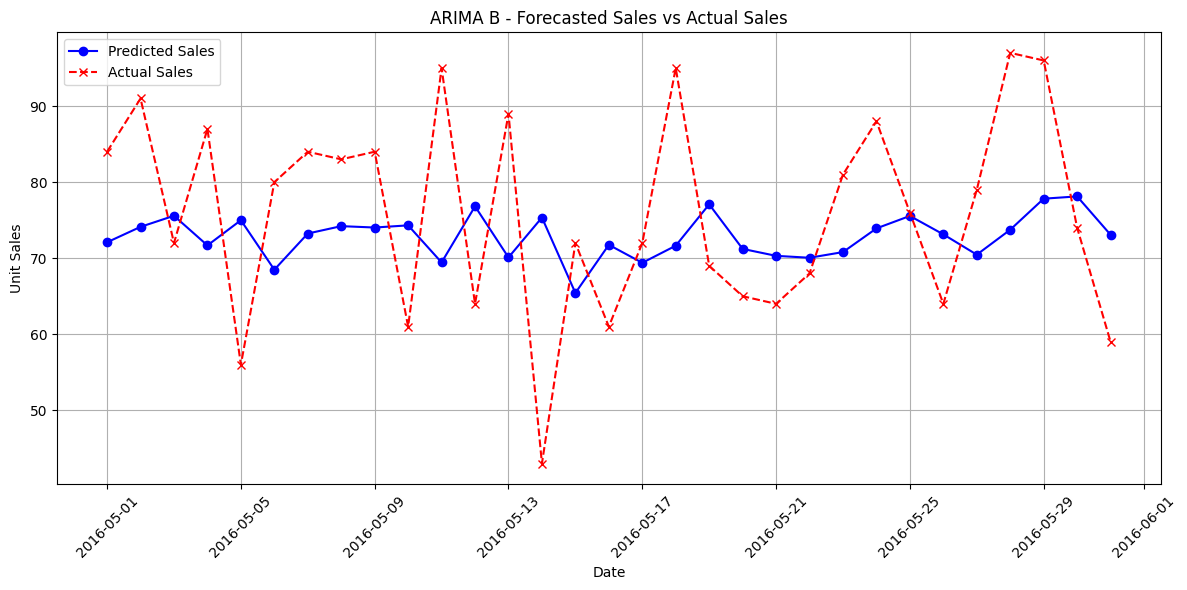

In [ ]:
# Model ARIMA B
model_name_ARIMA_B = 'ARIMA B'
plot_forecast_vs_actual(predictions_ARIMA_B, actual_data_ARIMA_B, model_name_ARIMA_B)

# Holt's Winter Exponential Smoothing models

Like the ARIMA model, I will also try to find the best parameters for the model with a grid search. I set the seasonal period to 7 since the data exhibits weekly seasonality.








In [ ]:
# Model ES A

# Define the parameter grid
trend_ES_A = ['add', 'mul']
seasonal_ES_A = ['add', 'mul']
seasonal_periods_ES_A = [7]  # Weekly seasonality

# Prepare train and validation data
train_size_ES_A = int(len(train_A) * 0.8)
train_data_ES_A = train_A['unit_sales'].iloc[:train_size_ES_A]
validation_data_ES_A = train_A['unit_sales'].iloc[train_size_ES_A:]

best_rmse_ES_A = np.inf
best_params_ES_A = None

# Grid search
for tr in trend_ES_A:
    for se in seasonal_ES_A:
        for sp in seasonal_periods_ES_A:
            model_ES_A = ExponentialSmoothing(train_data_ES_A, trend=tr, seasonal=se, seasonal_periods=sp)
            model_fit_ES_A = model_ES_A.fit()
            forecast_ES_A = model_fit_ES_A.forecast(len(validation_data_ES_A))
            rmse = np.sqrt(mean_squared_error(validation_data_ES_A, forecast_ES_A))
            print(f"Parameters: trend={tr}, seasonal={se}, seasonal_periods={sp}, RMSE={rmse}")
            if rmse < best_rmse_ES_A:
                best_rmse_ES_A = rmse
                best_params_ES_A = (tr, se, sp)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Parameters: trend=add, seasonal=add, seasonal_periods=7, RMSE=16.182024720827634
Parameters: trend=add, seasonal=mul, seasonal_periods=7, RMSE=17.13132624383357


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Parameters: trend=mul, seasonal=add, seasonal_periods=7, RMSE=16.174729118084457
Parameters: trend=mul, seasonal=mul, seasonal_periods=7, RMSE=17.22732643113214


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [ ]:
# Model ES B

# Define the parameter grid
trend_ES_B = ['add', 'mul']
seasonal_ES_B = [None]
seasonal_periods_ES_B = [None]  # No weekly seasonality

# Prepare train and validation data
train_size_ES_B = int(len(train_B) * 0.8)
train_data_ES_B = train_B['unit_sales'].iloc[:train_size_ES_B]
validation_data_ES_B = train_B['unit_sales'].iloc[train_size_ES_B:]

best_rmse_ES_B = np.inf
best_params_ES_B = None

# Grid search
for tr in trend_ES_B:
    for se in seasonal_ES_B:
        for sp in seasonal_periods_ES_B:
            model_ES_B = ExponentialSmoothing(train_data_ES_B, trend=tr, seasonal=se, seasonal_periods=sp)
            model_fit_ES_B = model_ES_B.fit()
            forecast_ES_B = model_fit_ES_B.forecast(len(validation_data_ES_B))
            rmse = np.sqrt(mean_squared_error(validation_data_ES_B, forecast_ES_B))
            print(f"Parameters: trend={tr}, seasonal={se}, seasonal_periods={sp}, RMSE={rmse}")
            if rmse < best_rmse_ES_B:
                best_rmse_ES_B = rmse
                best_params_ES_B = (tr, se, sp)


Parameters: trend=add, seasonal=None, seasonal_periods=None, RMSE=18.70777941074257
Parameters: trend=mul, seasonal=None, seasonal_periods=None, RMSE=18.718910687324364


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
print(f"Best Parameters: trend={best_params_ES_A[0]}, seasonal={best_params_ES_A[1]}, seasonal_periods={best_params_ES_A[2]}, Best RMSE={best_rmse_ES_A}")
print(f"Best Parameters: trend={best_params_ES_B[0]}, seasonal={best_params_ES_B[1]}, seasonal_periods={best_params_ES_B[2]}, Best RMSE={best_rmse_ES_B}")

Best Parameters: trend=mul, seasonal=add, seasonal_periods=7, Best RMSE=16.174729118084457
Best Parameters: trend=add, seasonal=None, seasonal_periods=None, Best RMSE=18.70777941074257


## Result Model ES A

As the evaluation function has already been defined earlier, I will directly calculate the results.

In [ ]:
# Model ES A

def forecast_sales_ES_A(data, test_start_date, test_end_date):
    current_date = pd.to_datetime(test_start_date)
    end_date = pd.to_datetime(test_end_date)
    predictions = {}
    training_dates = []

    while current_date <= end_date:
        # Prepare training data for the current day
        train_data = prepare_training_data(data, str(current_date), str(current_date))
        train_start = current_date - timedelta(days=180)
        train_end = current_date - timedelta(days=1)

        # Train ES Model
        train_target = train_data['unit_sales']
        model_ES_A = ExponentialSmoothing(train_target, trend='mul', seasonal='add', seasonal_periods=7)
        model_ES_A_fit = model_ES_A.fit()

        # Predict for the current day
        prediction = model_ES_A_fit.forecast(steps=1)
        predictions[current_date.strftime('%Y-%m-%d')] = prediction[0]

        # Log training set start and end dates
        training_dates.append({'date': current_date.strftime('%Y-%m-%d'), 'start': train_start, 'end': train_end})

        # Move to the next day
        current_date += timedelta(days=1)

    return predictions, training_dates

Forecast the value for the evaluation period

In [ ]:
# Model ES A

# Define the testing period
test_start_date_ES_A = '2016-05-01'
test_end_date_ES_A = '2016-05-31'

# Run the forecast
predictions_ES_A, training_dates_ES_A = forecast_sales_ES_A(dataset_stat_A, test_start_date_ES_A, test_end_date_ES_A)
print("Forecasting completed.")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/sta

Forecasting completed.


Evaluate the results

In [ ]:
# Model ES A

# Extract actual sales data for the test period
actual_data_ES_A = dataset_stat_A[test_start_date_ES_A:test_end_date_ES_A]

# Check actual data extraction
print("Checking actual data extraction...")
if actual_data_ES_A.empty:
    print("Error: Actual data extraction returned an empty DataFrame.")
else:
    print(f"Actual data extracted for {len(actual_data_ES_A)} days.")

results_ES_A = evaluate_forecast(predictions_ES_A, actual_data_ES_A)
print(results_ES_A)

Checking actual data extraction...
Actual data extracted for 31 days.
              Metric       Value
0       Overall RMSE   14.349259
1             RMSE %   23.119909
2  Variance of RMSEs  107.653449
3        Overall MAE    9.912003
4              MAE %   15.970483
5       Overall MAPE   16.028407
6               Bias   -1.065300
7             Bias %   -1.716439


Predicted value for each day

In [ ]:
# Model ES A

print("Sample predictions:")
for date in list(predictions_ES_A.keys())[:]:
    print(f"{date}: {predictions_ES_A[date]}")

Sample predictions:
2016-05-01: 104.37532079485177
2016-05-02: 61.501625643808154
2016-05-03: 47.06205274024843
2016-05-04: 48.13548692358977
2016-05-05: 40.323254090485904
2016-05-06: 51.52757288770895
2016-05-07: 72.23801042848456
2016-05-08: 106.83570574839294
2016-05-09: 62.4550033884208
2016-05-10: 47.09166279679847
2016-05-11: 47.67848062025952
2016-05-12: 37.31157500468721
2016-05-13: 49.79182537974485
2016-05-14: 71.34348522991414
2016-05-15: 103.01556844655494
2016-05-16: 62.714747300961506
2016-05-17: 47.362762783623445
2016-05-18: 47.03902045536875
2016-05-19: 39.51950899856401
2016-05-20: 49.812668529999286
2016-05-21: 71.52403245430853
2016-05-22: 102.47988028838289
2016-05-23: 61.036329686687395
2016-05-24: 46.26261047600571
2016-05-25: 45.34743217801901
2016-05-26: 38.539321297766335
2016-05-27: 48.02614640572067
2016-05-28: 71.55631920415787
2016-05-29: 102.44511942865512
2016-05-30: 60.8502466225973
2016-05-31: 45.772938254611475


Visualization of the results

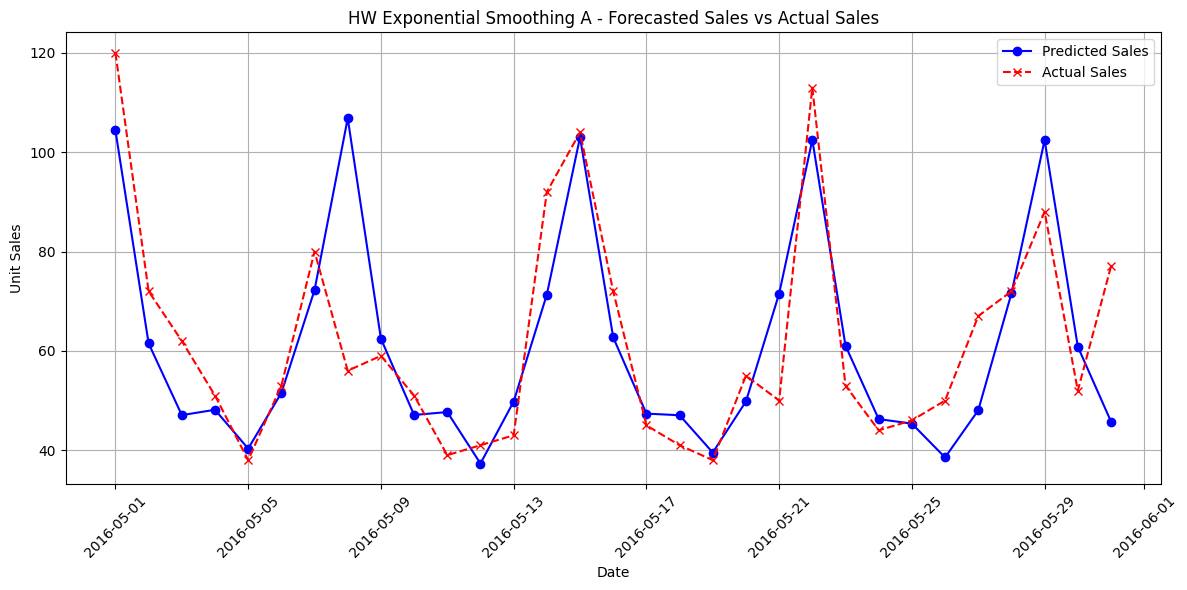

In [ ]:
# Model ES A

model_name_ES_A = 'HW Exponential Smoothing A'
plot_forecast_vs_actual(predictions_ES_A, actual_data_ES_A, model_name_ES_A)

## Result Model ES B

As the evaluation function has already been defined earlier, I will directly calculate the results.

In [ ]:
# Model ES B

def forecast_sales_ES_B(data, test_start_date, test_end_date):
    current_date = pd.to_datetime(test_start_date)
    end_date = pd.to_datetime(test_end_date)
    predictions = {}
    training_dates = []

    while current_date <= end_date:
        # Prepare training data for the current day
        train_data = prepare_training_data(data, str(current_date), str(current_date))
        train_start = current_date - timedelta(days=180)
        train_end = current_date - timedelta(days=1)

        # Train ES Model
        train_target = train_data['unit_sales']
        model_ES_B = ExponentialSmoothing(train_target, trend='add', seasonal=None, seasonal_periods=None)
        model_ES_B_fit = model_ES_B.fit()

        # Predict for the current day
        prediction = model_ES_B_fit.forecast(steps=1)
        predictions[current_date.strftime('%Y-%m-%d')] = prediction[0]

        # Log training set start and end dates
        training_dates.append({'date': current_date.strftime('%Y-%m-%d'), 'start': train_start, 'end': train_end})

        # Move to the next day
        current_date += timedelta(days=1)

    return predictions, training_dates

Forecast the value for the evaluation period

In [ ]:
# Model ES B

# Define the testing period
test_start_date_ES_B = '2016-05-01'
test_end_date_ES_B = '2016-05-31'

# Run the forecast
predictions_ES_B, training_dates_ES_B = forecast_sales_ES_B(dataset_stat_B, test_start_date_ES_B, test_end_date_ES_B)
print("Forecasting completed.")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Forecasting completed.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Evaluate the results

In [ ]:
# Model ES B

# Extract actual sales data for the test period
actual_data_ES_B = dataset_stat_B[test_start_date_ES_B:test_end_date_ES_B]

# Check actual data extraction
print("Checking actual data extraction...")
if actual_data_ES_B.empty:
    print("Error: Actual data extraction returned an empty DataFrame.")
else:
    print(f"Actual data extracted for {len(actual_data_ES_B)} days.")

results_ES_B = evaluate_forecast(predictions_ES_B, actual_data_ES_B)
print(results_ES_B)

Checking actual data extraction...
Actual data extracted for 31 days.
              Metric      Value
0       Overall RMSE  13.947735
1             RMSE %  18.375681
2  Variance of RMSEs  54.216743
3        Overall MAE  11.845783
4              MAE %  15.606429
5       Overall MAPE  16.534391
6               Bias  -1.723929
7             Bias %  -2.271220


Predicted value for each day

In [ ]:
#Model ES B

print("Sample predictions:")
for date in list(predictions_ES_B.keys())[:]:
    print(f"{date}: {predictions_ES_B[date]}")

Sample predictions:
2016-05-01: 69.24445360908017
2016-05-02: 75.52640197969703
2016-05-03: 72.27163616780486
2016-05-04: 72.29688471439316
2016-05-05: 73.67403700849796
2016-05-06: 72.07408906785247
2016-05-07: 72.97120885037793
2016-05-08: 73.91896507384804
2016-05-09: 74.81024580119865
2016-05-10: 75.77547737604786
2016-05-11: 74.40392237140904
2016-05-12: 76.3014812371999
2016-05-13: 75.42350508118774
2016-05-14: 76.76155477974919
2016-05-15: 74.11095916583811
2016-05-16: 73.80568652885903
2016-05-17: 72.8448583268727
2016-05-18: 72.93221270853442
2016-05-19: 74.65007960340179
2016-05-20: 74.34457351750166
2016-05-21: 73.64572335610686
2016-05-22: 72.9039377241224
2016-05-23: 72.62486032339594
2016-05-24: 73.37100154749398
2016-05-25: 74.62398197176044
2016-05-26: 74.54294225623931
2016-05-27: 73.76481988255811
2016-05-28: 74.37593110322268
2016-05-29: 76.30698172722586
2016-05-30: 77.67286344011076
2016-05-31: 77.58292024651388


Visualization of the results

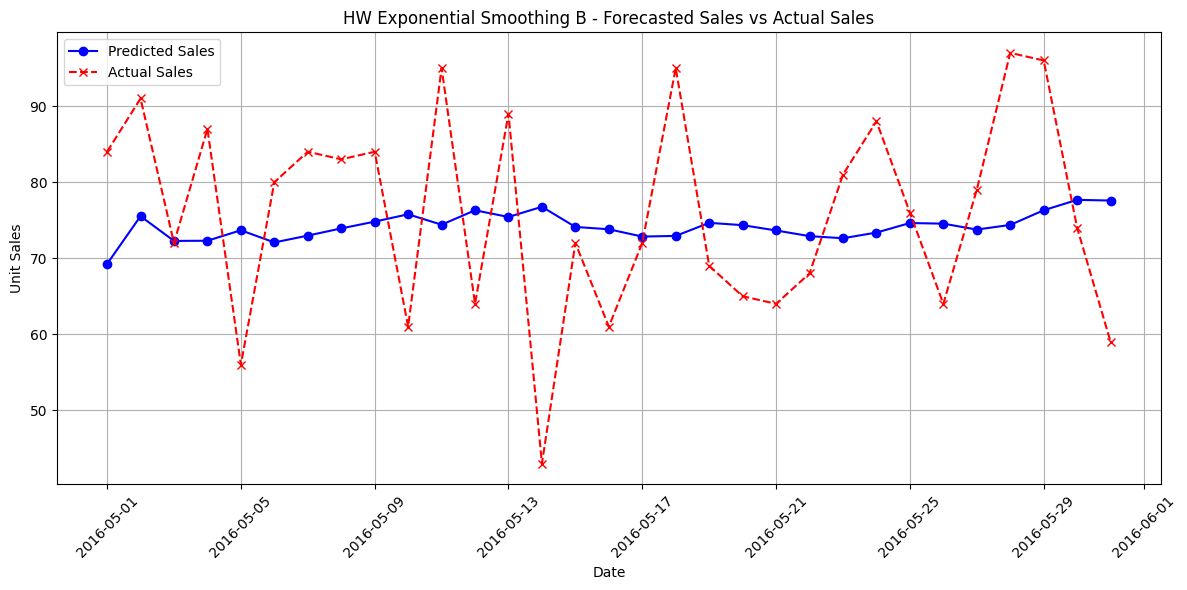

In [ ]:
# Model ES B

model_name_ES_B = 'HW Exponential Smoothing B'
plot_forecast_vs_actual(predictions_ES_B, actual_data_ES_B, model_name_ES_B)